In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

import pywt

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold

import joblib
from google.colab import files


In [ ]:
import random
import os

#  Fixing the seed for allowing reproductivity
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

In [ ]:
#  NSE
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse


In [ ]:
from scipy.stats import levy_stable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


HyMoLAP

In [ ]:
daily = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Bonou.xlsx')

discharge = daily.iloc[:1461, 0].to_numpy()
plui = daily.iloc[:1461, 1].to_numpy()
etp = daily.iloc[:1461, 2].to_numpy()


#Compute the Effective precipitation
prec_eff = plui - etp
prec_eff[prec_eff < 0] = 0

# X(t)
def state_basin(MU, LANDA, q):
    n = len(q)
    X = np.zeros(n)
    X[0] = q[0]
    for i in range(1, n):
        if q[i] == 0:
            X[i] = X[i - 1] - (MU / LANDA) * X[i - 1]
        else:
            X[i] = X[i - 1] + (MU / LANDA) * q[i]
    return X

# parameters obtained after Sto. HyMoLAP calibration
mu = 0.8136   # which is a in the paper
lambd = 2.9416   # which is b in the paper
sigma = 0.0035    # which is theta in the paper

# Lévy process parameters obtained after Sto. HyMoLAP calibration
alpha = 1.3
beta =  -0.8
gammaa = 1
delta = 0

#X(t)
X = state_basin(mu, lambd, prec_eff)

n_traj = 300000      # Large number of trajectories for allowing robust estimation of the distribution properties
QQ = np.zeros((len(discharge),n_traj))

for i in range(n_traj):

   #Simulate Lévy process
   Lev=[]
   Lev = levy_stable.rvs(alpha, beta, loc=delta, scale=gammaa, size=len(discharge))

   #Model
   S = np.zeros(len(discharge))
   S[0] = discharge[0]
   for k in range(1, len(discharge)):
        if S[k - 1]<0:
          S[k - 1] = 0
        S[k] = S[k - 1] - (mu/lambd) * S[k-1]**(2*mu-1) + (1/lambd) * X[k-1] * prec_eff[k-1] + sigma * S[k - 1] * (Lev[k]-Lev[k - 1])

   QQ[:, i] = S.copy()

mean_trajectory = np.mean(QQ, axis=1)
var_trajectory = np.std(QQ, axis=1)** 2

# Variation of quantile level between 0 and 0.25 with a step of 0.001
quantile_levels = np.arange(0, 0.251, 0.001)
quantile_results = {}

for q_level in quantile_levels:
    min_trajectory = pd.DataFrame(QQ).quantile(q_level, axis=1).to_numpy()
    max_trajectory = pd.DataFrame(QQ).quantile(1 - q_level, axis=1).to_numpy()
    diff = max_trajectory - min_trajectory

    # Store results for each quantile level
    quantile_results[q_level] = {
        'min_trajectory': min_trajectory,
        'max_trajectory': max_trajectory,
        'diff': diff
    }


Validation of HyMoLAP

In [ ]:
discharge1 = daily.iloc[1461:, 0].to_numpy()
plui1 = daily.iloc[1461:, 1].to_numpy()
etp1 = daily.iloc[1461:, 2].to_numpy()

#Compute the Effective precipitation
plui_eff1 = plui1 - etp1
plui_eff1[plui_eff1 < 0] = 0

# Simulation with the SDE
size = len(discharge1)
n_traj = 300000
QQ = np.zeros((size,n_traj))

X = state_basin(mu, lambd, plui_eff1)

for i in range(n_traj):

   #Simulate Lévy process
   Lev=[]
   Lev = levy_stable.rvs(alpha, beta, loc=delta, scale=gammaa, size=size)

   #EQUATION
   S = np.zeros(size)
   S[0] = discharge1[0]
   for k in range(1, size):
        if S[k - 1]<0:
          S[k - 1] = 0
        S[k] = S[k - 1] - (mu/lambd) * S[k-1]**(2*mu-1) + (1/lambd) * X[k-1] * plui_eff1[k-1] + sigma * S[k - 1] * (Lev[k]-Lev[k - 1])

   QQ[:, i] = S.copy()

mean_trajectory1 = np.mean(QQ, axis=1)
var_trajectory1 = np.std(QQ, axis=1)** 2

# Variation of quantile level between 0 and 0.4 with a step of 0.001
quantile_levels = np.arange(0, 0.251, 0.001)
quantile_results1 = {}

for q_level in quantile_levels:
    min_trajectory1 = pd.DataFrame(QQ).quantile(q_level, axis=1).to_numpy()
    max_trajectory1 = pd.DataFrame(QQ).quantile(1 - q_level, axis=1).to_numpy()
    diff1 = max_trajectory1 - min_trajectory1

    # Store results for each quantile level
    quantile_results1[q_level] = {
        'min_trajectory1': min_trajectory1,
        'max_trajectory1': max_trajectory1,
        'diff1': diff1
    }


HYBRID

In [ ]:
# Preparation of data with different cases (min, max, diff) and delays
def prepare_data(mean_trajectory, diff, var_trajectory, min_trajectory, max_trajectory, plui, etp, discharge):
    data = pd.DataFrame({
    'mean_HyMoLAP': mean_trajectory[2:-1],
    'diff_HyMoLAP': diff[2:-1],
    'min_HyMoLAP' : min_trajectory[2:-1],
    'max_HyMoLAP' : max_trajectory[2:-1],
    'var_HyMoLAP' : var_trajectory[2:-1],
    'plui_HyMoLAP': plui[2:-1],
    'etp_HyMoLAP': etp[2:-1],
    'target': discharge[3:]
    })

    # Addition of delayed columns (t-1, t-2, t-3)
    data['mean_HyMoLAP_t1'] = mean_trajectory[1:-2]
    data['diff_HyMoLAP_t1'] = diff[1:-2]
    data['min_HyMoLAP_t1'] = min_trajectory[1:-2]
    data['max_HyMoLAP_t1'] = max_trajectory[1:-2]
    data['var_HyMoLAP_t1'] = var_trajectory[1:-2]
    data['plui_HyMoLAP_t1'] = plui[1:-2]
    data['etp_HyMoLAP_t1'] = etp[1:-2]

    data['mean_HyMoLAP_t2'] = mean_trajectory[:-3]
    data['diff_HyMoLAP_t2'] = diff[:-3]
    data['min_HyMoLAP_t2'] = min_trajectory[:-3]
    data['max_HyMoLAP_t2'] = max_trajectory[:-3]
    data['var_HyMoLAP_t2'] = var_trajectory[:-3]
    data['plui_HyMoLAP_t2'] = plui[:-3]
    data['etp_HyMoLAP_t2'] = etp[:-3]

    return data


In [ ]:
# Define quantile levels to iterate over
quantile_levels = np.arange(0, 0.251, 0.001)

nse_values = []  # List to store Nash-Sutcliffe Efficiency (NSE) values
best_model = None  # Variable to store the best model found during optimization

for q_level in quantile_levels:
    # Prepare training and testing data for the current quantile level
    data_train = prepare_data(mean_trajectory, quantile_results[q_level]['diff'], var_trajectory,
                              quantile_results[q_level]['min_trajectory'], quantile_results[q_level]['max_trajectory'],
                              plui, etp, discharge)

    data_test = prepare_data(mean_trajectory1, quantile_results1[q_level]['diff1'], var_trajectory1,
                              quantile_results1[q_level]['min_trajectory1'], quantile_results1[q_level]['max_trajectory1'],
                              plui1, etp1, discharge1)

    # Split features and target variables for training and testing data
    X_train = data_train[['mean_HyMoLAP', 'diff_HyMoLAP', 'min_HyMoLAP', 'max_HyMoLAP',
                           'mean_HyMoLAP_t1', 'diff_HyMoLAP_t1', 'min_HyMoLAP_t1', 'max_HyMoLAP_t1',
                           'mean_HyMoLAP_t2', 'diff_HyMoLAP_t2', 'min_HyMoLAP_t2', 'max_HyMoLAP_t2']]
    y_train = data_train['target']

    X_test = data_test[['mean_HyMoLAP', 'diff_HyMoLAP', 'min_HyMoLAP', 'max_HyMoLAP',
                           'mean_HyMoLAP_t1', 'diff_HyMoLAP_t1', 'min_HyMoLAP_t1', 'max_HyMoLAP_t1',
                           'mean_HyMoLAP_t2', 'diff_HyMoLAP_t2', 'min_HyMoLAP_t2', 'max_HyMoLAP_t2']]
    y_test = data_test['target']

    # Define a wavelet transform function to preprocess data
    def wavelet_transform(data, wavelet='coif1', level=6):
        # Perform wavelet decomposition
        coeffs = pywt.wavedec(data, wavelet, level=level)
        approx_coeffs = coeffs[0]  # Extract approximation coefficients
        # Reconstruct data using only approximation coefficients
        transformed_data = pywt.waverec([approx_coeffs] + [None] * (len(coeffs) - 1), wavelet)
        return transformed_data[:len(data)]

    # Define wavelet types and decomposition levels
    # We tested various wavelet levels and wavelet types, as highlighted in the paper, before selecting the ones retained here.
    wavelet_levels = [4]
    wavelet_types = ['coif1']

    # Dictionary to store NSE results for each wavelet and level combination
    nse_results = {}

    for wavelet in wavelet_types:
        for level in wavelet_levels:
            # Apply wavelet transform to training and testing data
            X_train_wavelet = X_train.apply(lambda x: wavelet_transform(x, wavelet=wavelet, level=level), axis=0)
            X_test_wavelet = X_test.apply(lambda x: wavelet_transform(x, wavelet=wavelet, level=level), axis=0)

            # Define a pipeline with data scaling and XGBoost regressor
            xgb_pipeline = Pipeline([
                ('scaler', StandardScaler()),  # Standardize features
                ('xgb', XGBRegressor(random_state=42, subsample=0.6))  # XGBoost model
            ])

            # Define a parameter grid for hyperparameter tuning
            param_grid = {
                'xgb__n_estimators': [50, 100, 150],  # Number of trees
                'xgb__max_depth': [2, 3, 5],  # Tree depth
                'xgb__learning_rate': [0.01, 0.05],  # Learning rate
                'xgb__colsample_bytree': [0.5, 0.7, 0.9],  # Subsampling columns
                'xgb__reg_alpha': [0.1, 0.3, 0.5],  # L1 regularization
                'xgb__reg_lambda': [0.1, 0.3, 0.5],  # L2 regularization
            }

            # Use KFold cross-validation for hyperparameter tuning
            cv = KFold(n_splits=5, shuffle=True, random_state=42)

            # Randomized search for hyperparameter optimization
            grid_search = RandomizedSearchCV(xgb_pipeline, param_grid, n_iter=50, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

            # Fit the model on training data
            grid_search.fit(X_train_wavelet, y_train)

            # Retrieve the best model from grid search
            best_xgb = grid_search.best_estimator_

            # Predict on training and testing data
            y_pred_train = best_xgb.predict(X_train_wavelet)
            y_pred_test = best_xgb.predict(X_test_wavelet)

            # Calculate NSE for training and testing data
            nse_train = nash_sutcliffe_efficiency(discharge[3:1461], y_pred_train)
            nse_test = nash_sutcliffe_efficiency(y_test, y_pred_test)

            # Append test NSE to the list for overall evaluation
            nse_values.append(nse_test)

            # Store NSE results for the current wavelet and level
            nse_results[(wavelet, level)] = (nse_train, nse_test)
            print(f"q Level {q_level}: NSE Train = {nse_train}, NSE Test = {nse_test}")

            # Save the best model based on test NSE
            if best_model is None or nse_test > best_nse_test:
                best_model = best_xgb
                best_nse_test = nse_test

                # Store best parameters for reference
                best_params = grid_search.best_params_

# Save the best model and its parameters to files
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(best_params, 'best_params.pkl')
print("The best model is saved under the name: 'best_model.pkl'.")

# Load the saved model for future predictions
loaded_model = joblib.load('best_model.pkl')


q Level 0.0: NSE Train = 0.9881773480997134, NSE Test = 0.7406320356335563
q Level 0.001: NSE Train = 0.9875376302525346, NSE Test = 0.8058611955672274
q Level 0.002: NSE Train = 0.9931772455281451, NSE Test = 0.8057569268387881
q Level 0.003: NSE Train = 0.9933693567913168, NSE Test = 0.7953015936441005
q Level 0.004: NSE Train = 0.9933330613253114, NSE Test = 0.7903454999731642
q Level 0.005: NSE Train = 0.9932428486046613, NSE Test = 0.7882034523777759
q Level 0.006: NSE Train = 0.9942516671664079, NSE Test = 0.779801879144903
q Level 0.007: NSE Train = 0.9947485974394389, NSE Test = 0.7951726840613903
q Level 0.008: NSE Train = 0.9950025392087464, NSE Test = 0.801738776506152
q Level 0.009000000000000001: NSE Train = 0.994754104530095, NSE Test = 0.7998282037039416
q Level 0.01: NSE Train = 0.9904423490203828, NSE Test = 0.8258654374866131
q Level 0.011: NSE Train = 0.9936400491901826, NSE Test = 0.8171396242868022
q Level 0.012: NSE Train = 0.9942686593812018, NSE Test = 0.8332529

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

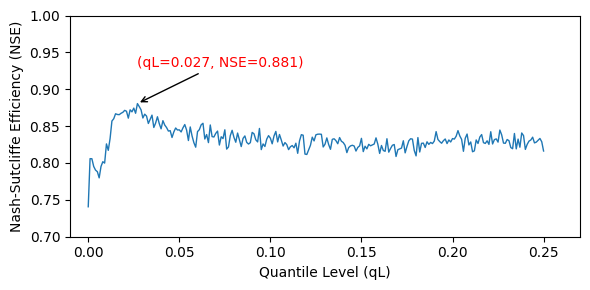

In [ ]:
# Find the index of the maximum NSE value
max_idx = np.argmax(nse_values)  # Index of the maximum NSE value
max_value = nse_values[max_idx]  # Maximum NSE value
max_quantile = quantile_levels[max_idx]  # Corresponding quantile level

# Plot NSE results with an arrow and text indicating the maximum NSE value
plt.figure(figsize=(6, 3))  # Set the figure size
plt.plot(quantile_levels, nse_values, linestyle='-', linewidth=1)  # Plot NSE values with a thin line
plt.xlabel('Quantile Level (qL)')  # Label for the x-axis
plt.ylabel('Nash-Sutcliffe Efficiency (NSE)')  # Label for the y-axis
# plt.grid()  # (Optional) Uncomment to display the grid
plt.xticks(np.arange(0, 0.5, 0.05))  # Adjust x-axis ticks as needed
plt.ylim(0.7, 1)  # Set the y-axis limits
plt.xlim(-0.01, 0.27)  # Limit the x-axis to the range [0, 0.27]

# Add an arrow and text indicating the maximum NSE value and corresponding quantile level
plt.annotate(f'(qL={max_quantile:.3f}, NSE={max_value:.3f})',  # Annotation text
             xy=(max_quantile, max_value),  # Point to annotate
             xytext=(max_quantile, max_value + 0.05),  # Position of the text
             arrowprops=dict(facecolor='red', arrowstyle="->"),  # Arrow style and color
             fontsize=10, color='red')  # Text font size and color

# Use tight_layout to prevent overlapping of labels and content
plt.tight_layout()

# Save the plot as a .jpeg file
plt.savefig("range.jpeg", format='jpeg', dpi=300)

# Download the saved file
files.download("range.jpeg")

# Display the plot
plt.show()


In [ ]:
# Use the saved model
# Prepare training and testing data for the selected quantile level
q_level = 0.027  # Manually set the best quantile level
data_train = prepare_data(mean_trajectory, quantile_results[q_level]['diff'], var_trajectory,
                          quantile_results[q_level]['min_trajectory'], quantile_results[q_level]['max_trajectory'],
                          plui, etp, discharge)

data_test = prepare_data(mean_trajectory1, quantile_results1[q_level]['diff1'], var_trajectory1,
                         quantile_results1[q_level]['min_trajectory1'], quantile_results1[q_level]['max_trajectory1'],
                         plui1, etp1, discharge1)

# Split features and target variables for training and testing
X_train = data_train[['mean_HyMoLAP', 'diff_HyMoLAP', 'min_HyMoLAP', 'max_HyMoLAP',
                      'mean_HyMoLAP_t1', 'diff_HyMoLAP_t1', 'min_HyMoLAP_t1', 'max_HyMoLAP_t1',
                      'mean_HyMoLAP_t2', 'diff_HyMoLAP_t2', 'min_HyMoLAP_t2', 'max_HyMoLAP_t2']]
y_train = data_train['target']

X_test = data_test[['mean_HyMoLAP', 'diff_HyMoLAP', 'min_HyMoLAP', 'max_HyMoLAP',
                    'mean_HyMoLAP_t1', 'diff_HyMoLAP_t1', 'min_HyMoLAP_t1', 'max_HyMoLAP_t1',
                    'mean_HyMoLAP_t2', 'diff_HyMoLAP_t2', 'min_HyMoLAP_t2', 'max_HyMoLAP_t2']]
y_test = data_test['target']

# Wavelet transform function for preprocessing
def wavelet_transform(data, wavelet='coif1', level=6):
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(data, wavelet, level=level)
    approx_coeffs = coeffs[0]  # Use approximation coefficients
    # Reconstruct data using only the approximation coefficients
    transformed_data = pywt.waverec([approx_coeffs] + [None] * (len(coeffs) - 1), wavelet)
    return transformed_data[:len(data)]  # Ensure the output matches input length

# List of wavelet levels and types to apply
wavelet_levels = [4]  # Wavelet decomposition levels to test
wavelet_types = ['coif1']  # Types of wavelets to apply

# Apply wavelet transformation to training and testing data
for wavelet in wavelet_types:
    for level in wavelet_levels:
        # Apply wavelet transform on X_train and X_test
        X_train_wavelet = X_train.apply(lambda x: wavelet_transform(x, wavelet=wavelet, level=level), axis=0)
        X_test_wavelet = X_test.apply(lambda x: wavelet_transform(x, wavelet=wavelet, level=level), axis=0)

# Use the loaded model to make predictions on training and testing data
y_pred1 = loaded_model.predict(X_train_wavelet)  # Predictions for training data
y_pred_test = loaded_model.predict(X_test_wavelet)  # Predictions for testing data

# Calculate Nash-Sutcliffe Efficiency (NSE) for both datasets
nse_train = nash_sutcliffe_efficiency(y_train, y_pred1)  # NSE for training data
nse_test = nash_sutcliffe_efficiency(y_test, y_pred_test)  # NSE for testing data
print(f"q Level {q_level}: NSE Train = {nse_train}, NSE Test = {nse_test}")

# Load the saved best parameters (optional)
best_params = joblib.load('best_params.pkl')  # Load the best parameters
print("Best parameters from the loaded model:", best_params)


q Level 0.027: NSE Train = 0.9941547150149856, NSE Test = 0.8805385933288705
Meilleurs paramètres du modèle chargé : {'xgb__reg_lambda': 0.1, 'xgb__reg_alpha': 0.3, 'xgb__n_estimators': 150, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.05, 'xgb__colsample_bytree': 0.7}


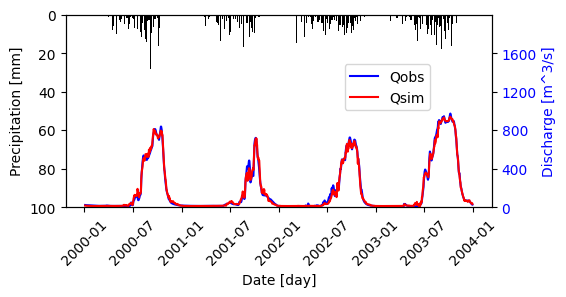

In [ ]:
# Create a range of dates from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2000-01-04')  # Start date
time2 = np.datetime64('2003-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')  # Daily date range

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(5.5, 2.5))

# Plot a histogram for precipitation (plui) on ax1
ax1.bar(time, plui[3:1461], color='black')  # Precipitation data as black bars

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))  # Display x-axis in Year-Month format
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

ax1.set_xlabel('Date [day]')  # Label for the x-axis

# Set y-axis parameters for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')  # Label for the left y-axis
ax1.tick_params(axis='y', labelcolor='black')  # Set tick color for the precipitation axis
ax1.set_ylim(0, 100)  # Set y-axis range for precipitation
ax1.set_yticks(np.arange(0, 101, 20))  # Set y-axis ticks at intervals of 20 mm

# Invert the y-axis and place ticks on the left side for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis for discharge data
ax2 = ax1.twinx()  # Share the same x-axis
ax2.plot(time, discharge[3:1461], 'b', label='Qobs')  # Plot observed discharge in blue

# Optional: Plot the minimum, maximum, and mean trajectories as a confidence region
# ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='95% CrI')

# Plot the predicted mean trajectory
ax2.plot(time, y_pred1, 'r', label='Qsim')  # Plot simulated discharge in red

# Set y-axis parameters for daily discharge
ax2.set_ylabel('Discharge [m^3/s]', color='blue')  # Label for the right y-axis
ax2.tick_params(axis='y', labelcolor='blue')  # Set tick color for the discharge axis
ax2.set_ylim(0, 2000)  # Set y-axis range for discharge
ax2.set_yticks(np.arange(0, 2000, 400))  # Set y-axis ticks at intervals of 400 m³/s

# Add a legend inside the plot area
fig.legend(loc='upper right', bbox_to_anchor=(0.8, 0.71))  # Place legend at the upper right


# Display the plot
plt.show()


Plots for validation

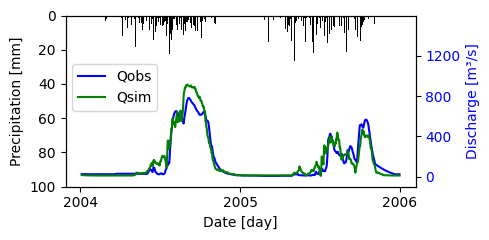

In [ ]:
import matplotlib.dates as mdates

# Generate the date range
time1 = np.datetime64('2004-01-04')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with specified dimensions
fig, ax1 = plt.subplots(figsize=(5., 2.5))

# Plot precipitation (plui1) as bars on ax1
ax1.bar(time, plui1[3:], color='black')

# Format the x-axis to show only the start of each year
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Align x-axis labels horizontally (no rotation)
plt.xticks(rotation=0)

# Label for the x-axis
ax1.set_xlabel('Date [day]')

# Configure y-axis for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")  # Position the y-axis label on the left

# Create a second y-axis for discharge (Qobs)
ax2 = ax1.twinx()
ax2.plot(time, discharge1[3:], 'b', label='Qobs')

# Plot the mean trajectories (Qsim)
ax2.plot(time, y_pred_test, 'green', label='Qsim')

# Configure y-axis for discharge
ax2.set_ylabel('Discharge [m³/s]', color='blue')  # Label for discharge axis
ax2.tick_params(axis='y', labelcolor='blue')  # Set tick color for the discharge axis
ax2.set_ylim(-100, 1600)  # Set y-axis range for discharge
ax2.set_yticks(np.arange(0, 1600, 400))  # Set y-axis ticks at intervals of 400 m³/s

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.14, 0.75))

# Use tight_layout to prevent label overlap
plt.tight_layout()

# Save the plot as a .jpeg file
plt.savefig("sto_hyb_wxgb.jpeg", format='jpeg', dpi=500)

# Optional: Download the saved file
# files.download("sto_hyb_wxgb.jpeg")

# Display the plot
plt.show()


In [ ]:
# Create a DataFrame to save the mean trajectory into an Excel file
df_mean_trajectory = pd.DataFrame({'Mean_Trajectory': y_pred_test})  # DataFrame with predicted mean trajectory

# Save the DataFrame to an Excel file
df_mean_trajectory.to_excel('Sto_wxgboost.xlsx', index=False)  # Save without including the index

# Download the file in Google Colab
files.download('Sto_wxgboost.xlsx')  # Prompt to download the saved Excel file

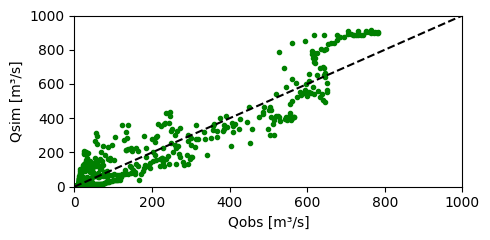

In [ ]:
# Scatter plot of observed (Qobs) vs simulated (Qsim) values
plt.figure(figsize=(5, 2.5))  # Set the figure size
plt.scatter(discharge1[3:], y_pred_test, color='green', marker='.')  # Scatter plot with observed and simulated values
plt.xlabel('Qobs [m³/s]')  # Label for the x-axis (observed discharge)
plt.ylabel('Qsim [m³/s]')  # Label for the y-axis (simulated discharge)

# Adjust the x and y-axis limits based on the data range
plt.xlim(0, 1000)  # Set x-axis limits from 0 to 1000
plt.ylim(0, 1000)  # Set y-axis limits from 0 to 1000

# Add a reference line (y = x) to indicate perfect fit
plt.plot([0, 1000], [0, 1000], color='black', linestyle='--')  # Dashed black line for reference

# Use tight_layout to avoid label clipping issues
plt.tight_layout()

# Save the plot as a .jpeg file before displaying it
plt.savefig("sca_sto_hyb_wxgb.jpeg", format='jpeg', dpi=500)

# Optional: Download the saved file to your laptop
# files.download("sca_sto_hyb_wxgb.jpeg")

# Display the plot
plt.show()


In [ ]:
!python --version


Python 3.10.12


In [ ]:
import google.colab
print(google.colab.__version__)

0.0.1a2
